In [331]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime 
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
# %matplotlib inline 
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.impute import SimpleImputer

import env

In [332]:
df = pd.read_csv(r'/Users/malachihale/codeup-data-science/time-series-exercises/saas.csv')

In [333]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [334]:
df.tail()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0
790457,2017-12-31,1029399,5790457,0.0,0.0


In [335]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.Month_Invoiced)).sort_values('ds').\
            groupby(['ds'])[['Amount']].sum()

In [336]:
df = prep_data(df)

In [337]:
df.head()

,Amount
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [338]:
df.head()

,Amount
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


## Split

In [339]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

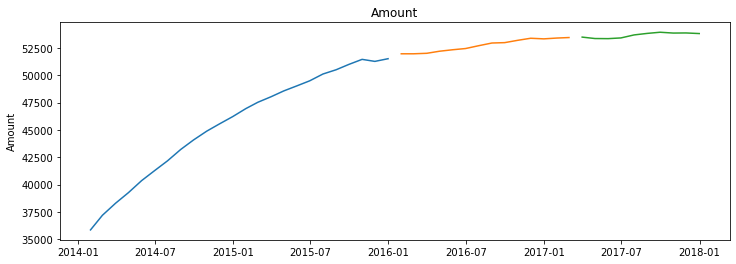

In [340]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Evaluative functions

In [341]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [342]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [343]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [344]:
eval_df

,model_type,target_var,rmse


## Forecast

### Simple Average

In [345]:
Amount = train['Amount'].mean()

def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [Amount]}
                           , index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [346]:
yhat_df.head(2)

,Amount
ds,
2016-01-31,45568.541667
2016-02-29,45568.541667


Amount -- RMSE: 7181


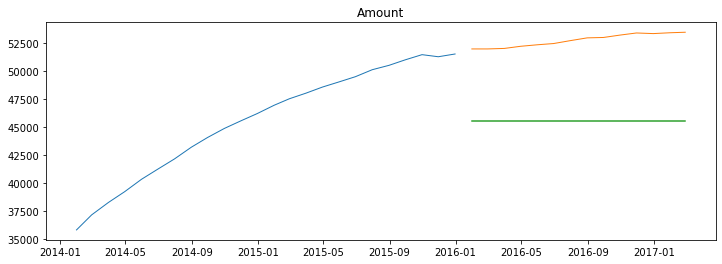

In [347]:
for col in train.columns:
    plot_and_eval(col)

In [348]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [349]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7181.0


### Moving Average 

In [350]:
period = 3

Amount = train['Amount'].rolling(period).median().iloc[-1]

yhat_df = make_predictions()
yhat_df.head(3)

,Amount
ds,
2016-01-31,51445.0
2016-02-29,51445.0
2016-03-31,51445.0


Amount -- RMSE: 1398


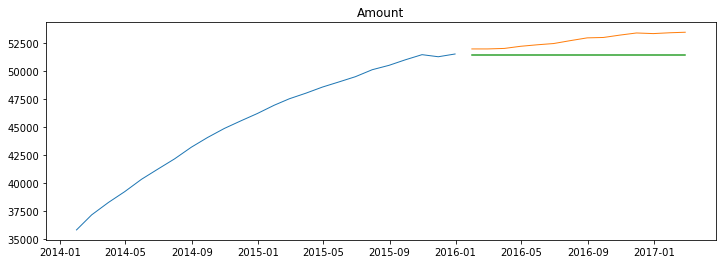

In [351]:
for col in train.columns:
    plot_and_eval(col)

In [352]:
for col in train.columns:
    eval_df = append_eval_df(model_type='3 month moving average', 
                             target_var = col)

In [353]:
periods = [1, 4, 8, 12, 24]

for p in periods:
    Amount = train['Amount'].rolling(p).mean().iloc[-1]

    yhat_df = make_predictions()
    model_type = str(p) + ' month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Amount')
    

In [354]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7181.0
1,3 month moving average,Amount,1398.0
2,1 month moving average,Amount,1343.0
3,4 month moving average,Amount,1533.0
4,8 month moving average,Amount,2259.0
5,12 month moving average,Amount,3164.0
6,24 month moving average,Amount,7181.0


### Holt's Linear Trend

Amount 



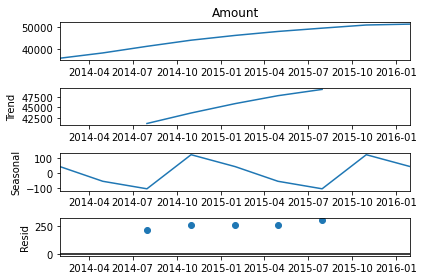

In [355]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

In [357]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [358]:
yhat_df.head(3)

,Amount
ds,
2016-01-31,56126.18
2016-02-29,56803.68
2016-03-31,57481.18


Amount -- RMSE: 8103


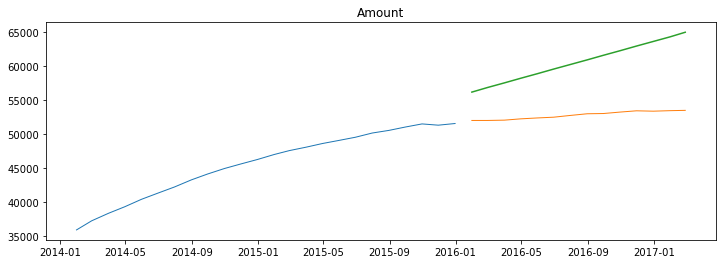

In [359]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [360]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [361]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7181.0
1,3 month moving average,Amount,1398.0
2,1 month moving average,Amount,1343.0
3,4 month moving average,Amount,1533.0
4,8 month moving average,Amount,2259.0
5,12 month moving average,Amount,3164.0
6,24 month moving average,Amount,7181.0
7,Holts,Amount,8103.0


### Predict Based on Previous Cycle

In [367]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [368]:
train.head(3)

,Amount
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0


In [371]:
train.tail(3)

,Amount
ds,
2015-10-31,51445.0
2015-11-30,51260.0
2015-12-31,51505.0


In [373]:
yhat_df = train['2015'] + train.diff(12).mean()

In [374]:
pd.concat([yhat_df.head(1), validate.head(1)])

,Amount
ds,
2015-01-31,55033.75
2016-01-31,51955.00


In [375]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

12

Amount -- RMSE: 5192


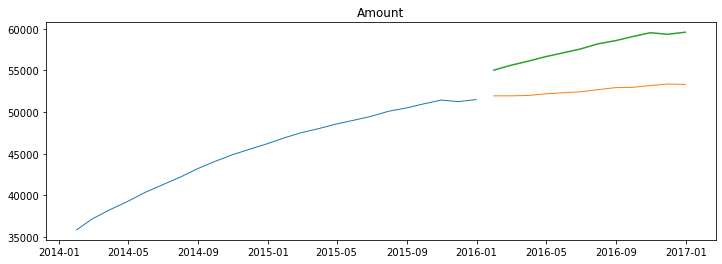

In [376]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

## Select Model

In [377]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7181.0
1,3 month moving average,Amount,1398.0
2,1 month moving average,Amount,1343.0
3,4 month moving average,Amount,1533.0
4,8 month moving average,Amount,2259.0
5,12 month moving average,Amount,3164.0
6,24 month moving average,Amount,7181.0
7,Holts,Amount,8103.0
8,previous year,Amount,5192.0


In [387]:
# get the min rmse for each variable

min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

In [389]:
min_rmse

1343.0

In [390]:
# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse))]

,model_type,target_var,rmse
2,1 month moving average,Amount,1343.0


Our **1 month moving average** model is our best model.

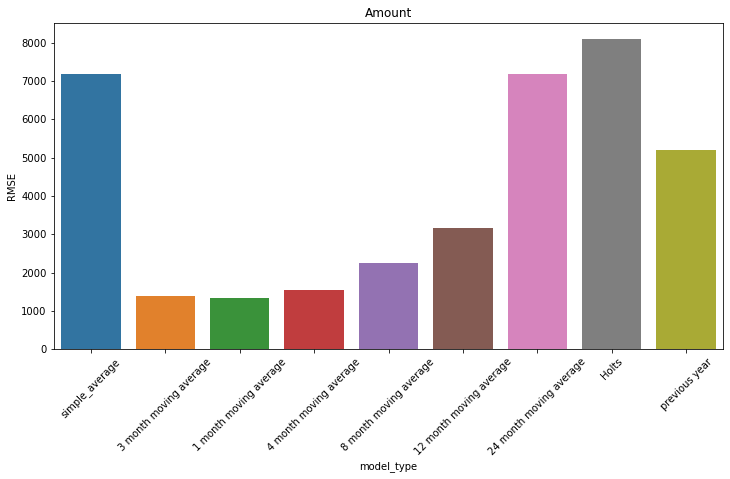

In [391]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [393]:
period = 1

Amount = test['Amount'].rolling(period).median().iloc[-1]

yhat_df = make_predictions()
yhat_df.head(3)

,Amount
ds,
2016-01-31,53805.0
2016-02-29,53805.0
2016-03-31,53805.0


In [394]:
yhat_df.index = test.index

In [396]:
rmse = round(sqrt(mean_squared_error(test['Amount'], yhat_df['Amount'])), 0)
rmse

292.0

In [398]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

rmse:  292.0


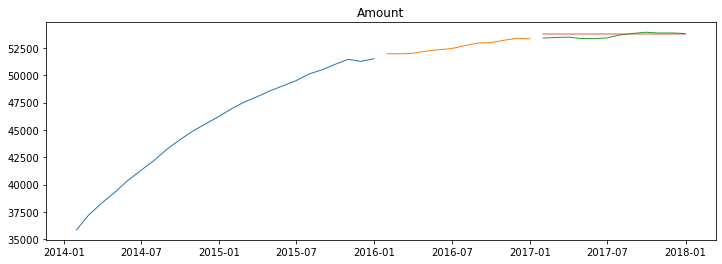

In [399]:
print("rmse: ", rmse)

for col in train.columns:
    plot_and_eval(col)

The model performs better than our simple average.